# XGBoost Experamentation

The purpose of this notebook will be to look at the XGBoost algorithm to see if we can better the baseline logistic regression model.

In [320]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [321]:
df = pd.read_csv('../data/finalized_customer_churn_records.csv')

In [322]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,...,Point Earned,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER
0,619,42,2,0.00,1,1,1,101348.88,1,1,...,464,1,0,0,1,0,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,...,456,0,0,1,1,0,1,0,0,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,...,377,1,0,0,1,0,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,...,350,1,0,0,1,0,0,1,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,...,425,0,0,1,1,0,0,1,0,0


In [323]:
target_variable = df['Exited'].values
df.drop('Exited', axis=1, inplace=True)

## Splitting dataset into training and testing sets

In [324]:
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

over_sampler = RandomOverSampler(sampling_strategy='minority')
df, target_variable = over_sampler.fit_resample(df, target_variable)

RANDOM_STATE = 3

X_train, X_test, y_train, y_test = train_test_split(df, target_variable, stratify=target_variable, random_state=RANDOM_STATE, test_size=0.30)

print(f'X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}\ny_train shape: {y_train.shape}\ny_test shape: {y_test.shape}')

# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


X_train shape: (11146, 20)
X_test shape: (4778, 20)
y_train shape: (11146,)
y_test shape: (4778,)


## Basic XGBoost model implementation

In [325]:
import xgboost as xgb

## basic xgb model

xgb_ = xgb.XGBClassifier(random_state=RANDOM_STATE, objective='binary:logistic', n_estimators=10)

%time
xgb_.fit(X_train, y_train, eval_metric='aucpr', early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=1)
#####################

# D_train = xgb.DMatrix(X_train, label=y_train)
# D_test = xgb.DMatrix(X_test, label=y_test)

# model = xgb.train(dtrain=D_train, params=None)

CPU times: user 3 µs, sys: 9 µs, total: 12 µs
Wall time: 37.2 µs
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99861
[6]	validation_0-aucpr:0.99861
[7]	validation_0-aucpr:0.99861
[8]	validation_0-aucpr:0.99861
[9]	validation_0-aucpr:0.99861


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=3, ...)

In [326]:

xgb_preds = xgb_.predict(X_test)
# best_preds = np.asarray([np.argmax(line) for line in xgb_preds])
# print(best_preds[:40])

In [327]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, xgb_preds))
confusion_matrix_ = confusion_matrix(y_test, xgb_preds)
print(f'False negative rate:\n{round(confusion_matrix_[0][1]/len(y_test), 2)*100}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2389
           1       1.00      1.00      1.00      2389

    accuracy                           1.00      4778
   macro avg       1.00      1.00      1.00      4778
weighted avg       1.00      1.00      1.00      4778

False negative rate:
0.0


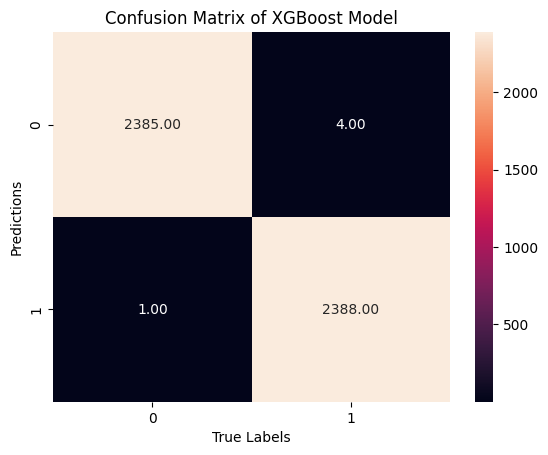

In [328]:
sns.heatmap(data=confusion_matrix_, annot=True, fmt='.2f')
plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title('Confusion Matrix of XGBoost Model')
plt.show()

We can see that the basic XGBoost model gives us nearly a 100% recall and f1-score

## Hyper-parameter tuning

In [329]:
##### hyper-parameter tuning

params = {
    'booster': ['gbtree', 'gblinear', 'dart'],
    'eta': [.0001, .001, .01],
    'max_depth': [3,4,5],
    'scale_pos_weight': [1,3,5]
}

xgb_grid = GridSearchCV(estimator=xgb_, param_grid=params, n_jobs=-1, verbose=False, cv=5, scoring=['f1_weighted', 'recall_macro'], refit='f1_weighted')

# xgb_.get_params()
xgb_grid.fit(X_train, y_train, eval_metric='aucpr', early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[0]	validation_0-aucpr:0.99849
[1]	validation_0-aucpr:0.99849
[2]	validation_0-aucpr:0.99849
[3]	validation_0-aucpr:0.99849
[4]	validation_0-aucpr:0.99849
[5]	validation_0-aucpr:0.99849
[6]	validation_0-aucpr:0.99849
[0]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99849
[1]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99849
[9]	validation_0-aucpr:0.99849
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99849
[3]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[6]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[8]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[5]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99849
[1]	validation_0-aucpr:0.99849
[2]	validation_0-aucpr:0.99849
[3]	validation_0-aucpr:0.99849
[4]	validation_0-aucpr:0.99849
[5]	validation_0-aucpr:0.99849
[0]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99849
[1]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99849
[2]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99849
[3]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99849
[4]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[1]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862[8]	validation_0-aucpr:0.99862

[9]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862[0]	validation_0-aucpr:0.99862

[1]	validation_0-aucpr:0.99861
[6]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99861
[3]	validation_0-aucpr:0.99861
[8]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[4]	validation_0-aucpr:0.99849
[6]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99849
[7]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99849
[5]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99849
[9]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99849
[8]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99849
[9]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99849
[5]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[3]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99861
[5]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99861
[6]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99861
[7]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99861
[8]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in


[4]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[4]	val

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[6]	validation_0-aucpr:0.99849
[2]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99849
[3]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99849
[4]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99849
[5]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[4]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99861
[2]	validation_0-aucpr:0.99861
[3]	validation_0-aucpr:0.99861
[8]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99861
[5]	validation_0-aucpr:0.99861
[6]	validation_0-aucpr:0.99861
[7]	validation_0-aucpr:0.99861
[9]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99861
[9]	validation_0-aucpr:0.99861
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99861
[4]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99861
[0]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99861
[5]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[3]	validation_0-aucpr:0.98247
[2]	validation_0-aucpr:0.98315
[3]	validation_0-aucpr:0.98313
[4]	validation_0-aucpr:0.98248
[4]	validation_0-aucpr:0.98314
[5]	validation_0-aucpr:0.98247
[5]	validation_0-aucpr:0.98315
[6]	validation_0-aucpr:0.98248
[6]	validation_0-aucpr:0.98315
[7]	validation_0-aucpr:0.98248
[7]	validation_0-aucpr:0.98315
[8]	validation_0-aucpr:0.98249
[8]	validation_0-aucpr:0.98316
[9]	validation_0-aucpr:0.98249
[9]	validation_0-aucpr:0.98315
[0]	validation_0-aucpr:0.98367
[1]	validation_0-aucpr:0.98364
[2]	validation_0-aucpr:0.98367
[3]	validation_0-aucpr:0.98364
[4]	validation_0-aucpr:0.98366
[5]	validation_0-aucpr:0.98366
[6]	validation_0-aucpr:0.98366
[7]	validation_0-aucpr:0.98366
[0]	validation_0-aucpr:0.98360
[8]	validation_0-aucpr:0.98367
[9]	validation_0-aucpr:0.98366
[1]	validation_0-aucpr:0.98359
[2]	validation_0-aucpr:0.98361
[3]	validation_0-aucpr:0.98360
[4]	validation_0-aucpr:0.98362
[5]	validation_0-aucpr:0.98361
[6]	validation_0-aucpr:0.98361
[0]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:51:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:51:39] WARNING: /Users/runner/work/x

[7]	validation_0-aucpr:0.99682
[4]	validation_0-aucpr:0.99649
[5]	validation_0-aucpr:0.99649
[8]	validation_0-aucpr:0.99682
[9]	validation_0-aucpr:0.99682
[0]	validation_0-aucpr:0.98300
[6]	validation_0-aucpr:0.99649
[1]	validation_0-aucpr:0.98306
[0]	validation_0-aucpr:0.98245
[7]	validation_0-aucpr:0.99649
[0]	validation_0-aucpr:0.99678
[1]	validation_0-aucpr:0.98249
[2]	validation_0-aucpr:0.98303
[8]	validation_0-aucpr:0.99649
[1]	validation_0-aucpr:0.99678
[3]	validation_0-aucpr:0.98303
[9]	validation_0-aucpr:0.99649
[2]	validation_0-aucpr:0.99678
[2]	validation_0-aucpr:0.98248
[4]	validation_0-aucpr:0.98305
[3]	validation_0-aucpr:0.98247
[5]	validation_0-aucpr:0.98305
[4]	validation_0-aucpr:0.98248
[6]	validation_0-aucpr:0.98305
[5]	validation_0-aucpr:0.98247
[7]	validation_0-aucpr:0.98306
[6]	validation_0-aucpr:0.98248
[8]	validation_0-aucpr:0.98305
[3]	validation_0-aucpr:0.99678
[9]	validation_0-aucpr:0.98305
[4]	validation_0-aucpr:0.99679
[0]	validation_0-aucpr:0.98317
[5]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_

[4]	validation_0-aucpr:0.98314
[3]	validation_0-aucpr:0.98303
[5]	validation_0-aucpr:0.98315
[6]	validation_0-aucpr:0.98315
[6]	validation_0-aucpr:0.98248
[7]	validation_0-aucpr:0.98366
[7]	validation_0-aucpr:0.98248
[8]	validation_0-aucpr:0.98367
[4]	validation_0-aucpr:0.98305
[5]	validation_0-aucpr:0.98305
[8]	validation_0-aucpr:0.98249
[2]	validation_0-aucpr:0.98361
[0]	validation_0-aucpr:0.97336
[9]	validation_0-aucpr:0.98366
[9]	validation_0-aucpr:0.98249
[1]	validation_0-aucpr:0.97330
[6]	validation_0-aucpr:0.98305
[7]	validation_0-aucpr:0.98315
[3]	validation_0-aucpr:0.98360[8]	validation_0-aucpr:0.98316

[7]	validation_0-aucpr:0.98306
[9]	validation_0-aucpr:0.98315
[8]	validation_0-aucpr:0.98305
[4]	validation_0-aucpr:0.98362
[9]	validation_0-aucpr:0.98305
[5]	validation_0-aucpr:0.98361
[2]	validation_0-aucpr:0.97332
[6]	validation_0-aucpr:0.98361
[3]	validation_0-aucpr:0.97331
[4]	validation_0-aucpr:0.97335
[7]	validation_0-aucpr:0.98361
[5]	validation_0-aucpr:0.97338
[0]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[5]	validation_0-aucpr:0.97373
[6]	validation_0-aucpr:0.97374
[7]	validation_0-aucpr:0.97376
[0]	validation_0-aucpr:0.99682
[9]	validation_0-aucpr:0.99661
[1]	validation_0-aucpr:0.99682
[8]	validation_0-aucpr:0.97378
[2]	validation_0-aucpr:0.99681
[3]	validation_0-aucpr:0.99682
[0]	validation_0-aucpr:0.99648
[4]	validation_0-aucpr:0.99681
[1]	validation_0-aucpr:0.99648
[9]	validation_0-aucpr:0.97379
[2]	validation_0-aucpr:0.99649
[3]	validation_0-aucpr:0.99649
[4]	validation_0-aucpr:0.99649
[5]	validation_0-aucpr:0.99681
[5]	validation_0-aucpr:0.99650
[6]	validation_0-aucpr:0.99681
[6]	validation_0-aucpr:0.99650
[7]	validation_0-aucpr:0.99650
[8]	validation_0-aucpr:0.99651
[0]	validation_0-aucpr:0.98314
[1]	validation_0-aucpr:0.98317
[2]	validation_0-aucpr:0.98319
[0]	validation_0-aucpr:0.98248
[0]	validation_0-aucpr:0.98304
[9]	validation_0-aucpr:0.99651
[3]	validation_0-aucpr:0.98321
[7]	validation_0-aucpr:0.99682
[1]	validation_0-aucpr:0.98251
[1]	validation_0-aucpr:0.98307
[4]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:51:40] WARNING: /Users/runner/work/x

[4]	validation_0-aucpr:0.97298
[7]	validation_0-aucpr:0.97408
[5]	validation_0-aucpr:0.97310
[8]	validation_0-aucpr:0.97421
[0]	validation_0-aucpr:0.97367
[6]	validation_0-aucpr:0.97321
[9]	validation_0-aucpr:0.97432
[1]	validation_0-aucpr:0.97381
[7]	validation_0-aucpr:0.97332
[2]	validation_0-aucpr:0.97394
[8]	validation_0-aucpr:0.97345
[9]	validation_0-aucpr:0.97358
[3]	validation_0-aucpr:0.97408
[4]	validation_0-aucpr:0.97418
[5]	validation_0-aucpr:0.97431
[6]	validation_0-aucpr:0.97444
[7]	validation_0-aucpr:0.97458
[8]	validation_0-aucpr:0.97469
[9]	validation_0-aucpr:0.97482
[0]	validation_0-aucpr:0.97374
[1]	validation_0-aucpr:0.97388
[2]	validation_0-aucpr:0.97402
[3]	validation_0-aucpr:0.97416
[4]	validation_0-aucpr:0.97427
[5]	validation_0-aucpr:0.97439
[6]	validation_0-aucpr:0.97452
[0]	validation_0-aucpr:0.99660
[7]	validation_0-aucpr:0.97463
[1]	validation_0-aucpr:0.99660
[8]	validation_0-aucpr:0.97476
[2]	validation_0-aucpr:0.99661
[9]	validation_0-aucpr:0.97489
[3]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:51:40] WARNING: /Users/runner/work/x

[7]	validation_0-aucpr:0.98383
[0]	validation_0-aucpr:0.97337
[1]	validation_0-aucpr:0.97350
[8]	validation_0-aucpr:0.98384
[9]	validation_0-aucpr:0.98387
[2]	validation_0-aucpr:0.97365
[3]	validation_0-aucpr:0.97376
[0]	validation_0-aucpr:0.98361
[4]	validation_0-aucpr:0.97389
[1]	validation_0-aucpr:0.98364
[2]	validation_0-aucpr:0.98366
[5]	validation_0-aucpr:0.97400
[3]	validation_0-aucpr:0.98367
[6]	validation_0-aucpr:0.97412
[4]	validation_0-aucpr:0.98370
[7]	validation_0-aucpr:0.97425
[8]	validation_0-aucpr:0.97437
[9]	validation_0-aucpr:0.97447
[5]	validation_0-aucpr:0.98372
[6]	validation_0-aucpr:0.98375[0]	validation_0-aucpr:0.97317
[1]	validation_0-aucpr:0.97331

[0]	validation_0-aucpr:0.97367
[7]	validation_0-aucpr:0.98378
[1]	validation_0-aucpr:0.97381
[0]	validation_0-aucpr:0.97246
[2]	validation_0-aucpr:0.97394
[8]	validation_0-aucpr:0.98380
[2]	validation_0-aucpr:0.97344
[1]	validation_0-aucpr:0.97259
[3]	validation_0-aucpr:0.97408
[3]	validation_0-aucpr:0.97356
[9]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is depr

[0]	validation_0-aucpr:0.99666
[7]	validation_0-aucpr:0.99682
[8]	validation_0-aucpr:0.99685
[1]	validation_0-aucpr:0.99668
[2]	validation_0-aucpr:0.99670
[3]	validation_0-aucpr:0.99672
[4]	validation_0-aucpr:0.99676
[9]	validation_0-aucpr:0.99688
[0]	validation_0-aucpr:0.99684
[5]	validation_0-aucpr:0.99679
[1]	validation_0-aucpr:0.99685
[2]	validation_0-aucpr:0.99689
[6]	validation_0-aucpr:0.99683
[3]	validation_0-aucpr:0.99692
[7]	validation_0-aucpr:0.99687
[8]	validation_0-aucpr:0.99689
[0]	validation_0-aucpr:0.99652
[9]	validation_0-aucpr:0.99691
[1]	validation_0-aucpr:0.99656
[2]	validation_0-aucpr:0.99657
[4]	validation_0-aucpr:0.99695
[3]	validation_0-aucpr:0.99660
[5]	validation_0-aucpr:0.99698
[6]	validation_0-aucpr:0.99700
[7]	validation_0-aucpr:0.99702
[4]	validation_0-aucpr:0.99662
[0]	validation_0-aucpr:0.99682
[0]	validation_0-aucpr:0.98317
[1]	validation_0-aucpr:0.99684
[8]	validation_0-aucpr:0.99704
[1]	validation_0-aucpr:0.98338
[5]	validation_0-aucpr:0.99665
[2]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is depr

[7]	validation_0-aucpr:0.97852
[4]	validation_0-aucpr:0.97800
[5]	validation_0-aucpr:0.97867
[8]	validation_0-aucpr:0.97900
[9]	validation_0-aucpr:0.97945
[6]	validation_0-aucpr:0.97926
[7]	validation_0-aucpr:0.97978
[8]	validation_0-aucpr:0.98024
[9]	validation_0-aucpr:0.98068
[0]	validation_0-aucpr:0.97439
[1]	validation_0-aucpr:0.97555
[2]	validation_0-aucpr:0.97651
[3]	validation_0-aucpr:0.97737
[4]	validation_0-aucpr:0.97814
[5]	validation_0-aucpr:0.97878
[6]	validation_0-aucpr:0.97933
[7]	validation_0-aucpr:0.97985
[8]	validation_0-aucpr:0.98032
[0]	validation_0-aucpr:0.99664
[9]	validation_0-aucpr:0.98076
[1]	validation_0-aucpr:0.99665
[7]	validation_0-aucpr:0.98488
[2]	validation_0-aucpr:0.99666
[3]	validation_0-aucpr:0.99668
[4]	validation_0-aucpr:0.99671
[5]	validation_0-aucpr:0.99675
[8]	validation_0-aucpr:0.98498
[6]	validation_0-aucpr:0.99679
[9]	validation_0-aucpr:0.98513
[7]	validation_0-aucpr:0.99682
[8]	validation_0-aucpr:0.99685
[9]	validation_0-aucpr:0.99688
[0]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:51:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:51:41] WARNING: /Users/runner/work/x

[3]	validation_0-aucpr:0.97683
[4]	validation_0-aucpr:0.97760
[5]	validation_0-aucpr:0.97818
[6]	validation_0-aucpr:0.97878
[0]	validation_0-aucpr:0.97384
[7]	validation_0-aucpr:0.97930
[8]	validation_0-aucpr:0.97976
[1]	validation_0-aucpr:0.97497
[9]	validation_0-aucpr:0.98016
[2]	validation_0-aucpr:0.97595
[3]	validation_0-aucpr:0.97680
[4]	validation_0-aucpr:0.97755
[0]	validation_0-aucpr:0.97307
[5]	validation_0-aucpr:0.97821
[1]	validation_0-aucpr:0.97422
[6]	validation_0-aucpr:0.97882
[2]	validation_0-aucpr:0.97521
[7]	validation_0-aucpr:0.97933
[3]	validation_0-aucpr:0.97602
[8]	validation_0-aucpr:0.97979
[4]	validation_0-aucpr:0.97675
[9]	validation_0-aucpr:0.98022
[5]	validation_0-aucpr:0.97741
[6]	validation_0-aucpr:0.97802
[7]	validation_0-aucpr:0.97852
[8]	validation_0-aucpr:0.97900
[9]	validation_0-aucpr:0.97945
[0]	validation_0-aucpr:0.97432
[1]	validation_0-aucpr:0.97546
[2]	validation_0-aucpr:0.97642
[0]	validation_0-aucpr:0.97439
[3]	validation_0-aucpr:0.97727
[1]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[3]	validation_0-aucpr:0.98428
[8]	validation_0-aucpr:0.98455
[4]	validation_0-aucpr:0.98442
[9]	validation_0-aucpr:0.98468
[5]	validation_0-aucpr:0.98453
[8]	validation_0-aucpr:0.99702
[6]	validation_0-aucpr:0.98464
[8]	validation_0-aucpr:0.99704
[7]	validation_0-aucpr:0.98477
[9]	validation_0-aucpr:0.99706
[8]	validation_0-aucpr:0.98488
[9]	validation_0-aucpr:0.99707
[9]	validation_0-aucpr:0.98501
[6]	validation_0-aucpr:0.98370
[7]	validation_0-aucpr:0.98382
[0]	validation_0-aucpr:0.98371
[8]	validation_0-aucpr:0.98394
[1]	validation_0-aucpr:0.98394
[9]	validation_0-aucpr:0.98404
[2]	validation_0-aucpr:0.98416
[0]	validation_0-aucpr:0.97399
[3]	validation_0-aucpr:0.98433
[1]	validation_0-aucpr:0.97506
[2]	validation_0-aucpr:0.97604
[4]	validation_0-aucpr:0.98446
[3]	validation_0-aucpr:0.97683
[5]	validation_0-aucpr:0.98461
[4]	validation_0-aucpr:0.97760
[6]	validation_0-aucpr:0.98474
[5]	validation_0-aucpr:0.97818
[7]	validation_0-aucpr:0.98488
[0]	validation_0-aucpr:0.97384
[6]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:51:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is depr

[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99849
[1]	validation_0-aucpr:0.99849
[0]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99849
[2]	validation_0-aucpr:0.99849[1]	validation_0-aucpr:0.99862

[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99849
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99849
[4]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99849
[3]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[5]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[9]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99849
[0]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[3]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[7]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99849
[1]	validation_0-aucpr:0.99849
[5]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99849
[4]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99849
[6]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99849
[7]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[9]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99849
[9]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99849
[9]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99849
[0]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99849
[8]	validation_0-aucpr:0.99849
[2]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99849
[1]	validation_0-aucpr:0.99862


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[4]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99849
[5]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99849
[6]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99849
[4]	validation_0-aucpr:0.99849
[6]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99849
[2]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[6]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[0]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99849
[6]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99849
[5]	validation_0-aucpr:0.99862[9]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99849
[5]	validation_0-aucpr:0.99862

[5]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99849
[8]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99849
[6]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[6]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in


[6]	validation_0-aucpr:0.99849
[0]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99849
[7]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99861
[2]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99849
[8]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99861
[9]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99849
[4]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99861


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[9]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862[4]	validation_0-aucpr:0.99862

[0]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99849
[5]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99849
[2]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99849
[1]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99849
[8]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[3]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[5]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99849
[6]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862[4]	validation_0-aucpr:0.99862

[0]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99849


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[3]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99849
[9]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99849
[4]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99849
[6]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99861
[5]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99849
[0]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99849
[7]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99861
[5]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[9]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99849
[1]	validation_0-aucpr:0.99849
[3]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99849
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99849
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99849
[1]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99849
[6]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[1]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[1]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862[3]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862

[7]	validation_0-aucpr:0.99849
[2]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99849
[7]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99849
[8]	validation_0-aucpr:0.99862


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[7]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99849
[8]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99849
[1]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99849
[4]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862[5]	valid

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[8]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99849
[9]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99849
[9]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99849
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99849
[0]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99849
[9]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[8]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99849
[3]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99849
[0]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99849
[9]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99849
[6]	validation_0-aucpr:0.99862
[5]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[3]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99849
[0]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99861
[7]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99861
[8]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99861
[8]	validation_0-aucpr:0.99849
[8]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99861
[7]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99849
[9]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99861
[6]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99861
[9]	validation_0-aucpr:0.99862


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[0]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99861
[1]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99861
[2]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99849
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99849
[7]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99849
[1]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99861
[3]	validation_0-aucpr:0.99849
[2]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[5]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99849
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[8]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99849
[0]	validation_0-aucpr:0.99849
[1]	validation_0-aucpr:0.99849
[4]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99849
[1]	validation_0-aucpr:0.99862


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[5]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99849
[0]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99849
[0]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99849
[2]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99849
[4]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[3]	validation_0-aucpr:0.99861
[7]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99861
[7]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99849
[0]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99861
[9]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862[6]	validation_0-aucpr:0.99861

[0]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862[9]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862

[9]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99849
[7]	validation_0-aucpr:0.99861
[1]	validation_0-aucpr:0.99849
[1]	validation_0-aucpr:0.99862


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[3]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99849
[5]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99849
[4]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99861
[6]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99849
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99849
[2]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99861
[2]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99849
[2]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[3]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[9]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99849
[8]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99849
[6]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99849
[7]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99849
[5]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99849
[7]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99849
[6]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[1]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[2]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99849
[8]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99849
[3]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99849
[5]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99849
[2]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[6]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[7]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99849
[2]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99849
[8]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[3]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99849
[0]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99849
[7]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99849
[4]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99849
[2]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99849
[2]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99849
[7]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[0]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[9]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99849
[4]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99849
[5]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99849
[9]	validation_0-aucpr:0.99849
[1]	validation_0-aucpr:0.99849
[0]	validation_0-aucpr:0.99862
[9]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[9]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99849
[7]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99849
[8]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99861
[2]	validation_0-aucpr:0.99861
[9]	validation_0-aucpr:0.99849
[7]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99861


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[8]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99861
[3]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99861
[0]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99861
[5]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99861
[6]	validation_0-aucpr:0.99861
[2]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99849
[3]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99849
[6]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99861
[2]	validation_0-aucpr:0.99849
[7]	validation_0-aucpr:0.99861
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99849
[4]	validation_0-aucpr:0.99861
[4]	validation_0-aucpr:0.99862
[2]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[7]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99861
[0]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99849
[3]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99861
[2]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99861
[6]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99849
[8]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99861
[6]	validation_0-aucpr:0.99849
[4]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99849
[8]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99861
[0]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[8]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[1]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99861
[0]	validation_0-aucpr:0.99849
[3]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99849
[9]	validation_0-aucpr:0.99849
[2]	validation_0-aucpr:0.99849
[4]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99849
[8]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99861
[5]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99849
[9]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99849
[0]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[0]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[3]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99849
[3]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99849
[8]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99849
[6]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[6]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in

[5]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99849
[7]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99861
[8]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99861
[0]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99861
[7]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99861
[9]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99861
[8]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99861
[3]	validation_0-aucpr:0.99861
[8]	validation_0-aucpr:0.99862


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-aucpr:0.99861
[6]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99861
[9]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[5]	validation_0-aucpr:0.99861
[6]	validation_0-aucpr:0.99861
[2]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99861
[7]	validation_0-aucpr:0.99861
[4]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99862
[7]	validation_0-aucpr:0.99861
[5]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99861
[9]	validation_0-aucpr:0.99862
[6]	validation_0-aucpr:0.99862
[8]	validation_0-aucpr:0.99861
[9]	validation_0-aucpr:0.99861
[7]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99861
[8]	validation_0-aucpr:0.99862
[9]	validation_0-aucpr:0.99862
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99862
[4]	validation_0-aucpr:0.99862
[5]	vali

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=10,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=3, ...),
             n_jobs=-1,
             param_grid={'booster': ['gbtree', 'gblinear', 'dart'],
                         'eta': [0.0001, 0.001, 0.01], 'max_depth': [3, 4, 5],
                         'scale_pos_weight': [1, 3, 5]},
             refit='f1_weighted', scoring=['f1_weighted', 'recall_macro'],
             verbose=False)

In [330]:
y_pred = xgb_.predict(X_test)

print(f'XGBoost best params:\n{xgb_grid.best_params_}\n')
print(f'False negative rate:\n{confusion_matrix(y_test, y_pred)[0][1]/len(y_test)*100}')

XGBoost best params:
{'booster': 'gbtree', 'eta': 0.001, 'max_depth': 3, 'scale_pos_weight': 1}

False negative rate:
0.08371703641691085


In [331]:
params = {
    'booster': ['gbtree'],
    'learning_rate': [.001, .01, .1],
    'gamma': [.001, .01, .1],
    'max_depth': [3,4,5],
    'min_child_weight': [.01, 1, 2],
    'subsample': [0.5, 0.7, 0.9],
    'scale_pos_weight': [1,3,5],
    'colsample_bytree': [0.5, 0.7]
}

xgb_grid = GridSearchCV(estimator=xgb_, param_grid=params, cv=5, n_jobs=-1, verbose=False, scoring=['f1_weighted', 'recall_macro'], refit='f1_weighted')

xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=3, ...),
             n_jobs=-1,
             param_grid={'booster': ['gbtree'], 'colsample_bytree': [0.5, 0.7],
                         'gamma': [0.001, 0.01, 0.1],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 4, 5],
                         'min_child_weight': [0.01, 1, 2],
                         'scale_pos_weight': [1, 3, 5],
                         'subsample': [0.5, 0.7, 0.9]},
             refit='f1_weighted', scoring=['f1_weighted', 'recall_macro'],
             verbose=False)

In [332]:
print(f'XGBoost best params:\n{xgb_grid.best_params_}')

XGBoost best params:
{'booster': 'gbtree', 'colsample_bytree': 0.5, 'gamma': 0.001, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 0.01, 'scale_pos_weight': 1, 'subsample': 0.7}


In [333]:
xgb_ = xgb.XGBClassifier(random_state=RANDOM_STATE, objective='binary:logistic', booster='gbtree', learning_rate=0.01, max_depth=4, min_child_weight=0.001, subsample=0.9, scale_pos_weight=1, colsample_bytree=0.7)

%time
xgb_.fit(X_train, y_train, eval_metric='aucpr', early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=1)

CPU times: user 12 µs, sys: 24 µs, total: 36 µs
Wall time: 17.2 µs
[0]	validation_0-aucpr:0.99862
[1]	validation_0-aucpr:0.99862
[2]	validation_0-aucpr:0.99862
[3]	validation_0-aucpr:0.99965
[4]	validation_0-aucpr:0.99955
[5]	validation_0-aucpr:0.99952
[6]	validation_0-aucpr:0.99954
[7]	validation_0-aucpr:0.99955
[8]	validation_0-aucpr:0.99955
[9]	validation_0-aucpr:0.99956
[10]	validation_0-aucpr:0.99955
[11]	validation_0-aucpr:0.99955
[12]	validation_0-aucpr:0.99956


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=0.001, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=3, ...)

## Scoring

In [334]:
xgb_preds = xgb_.predict(X_test)
print(classification_report(y_test, xgb_preds))
print(f'False negative rate:\n{confusion_matrix(y_test, xgb_preds)[0][1]/len(y_test)*100}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2389
           1       1.00      1.00      1.00      2389

    accuracy                           1.00      4778
   macro avg       1.00      1.00      1.00      4778
weighted avg       1.00      1.00      1.00      4778

False negative rate:
0.08371703641691085


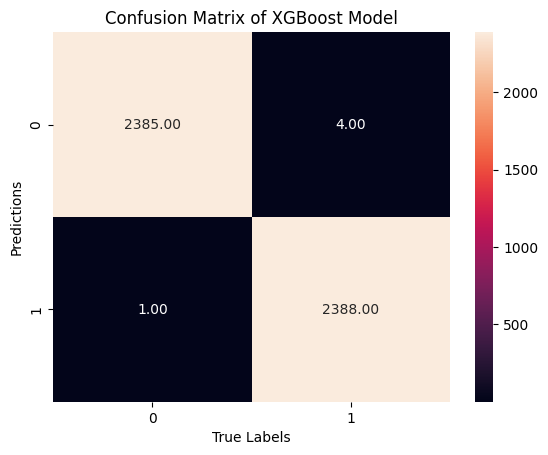

In [335]:
sns.heatmap(data=confusion_matrix(y_test, xgb_preds), annot=True, fmt='.2f')
plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title('Confusion Matrix of XGBoost Model')
plt.show()

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

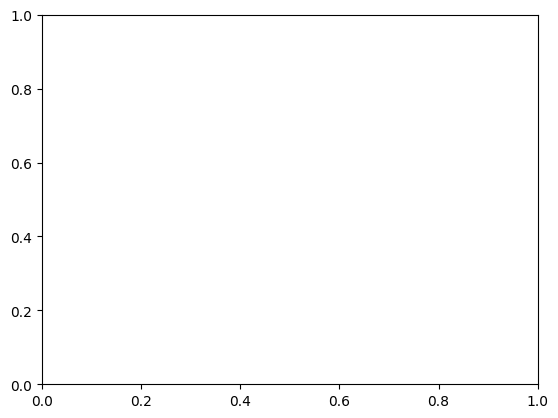

In [342]:
from xgboost import plot_tree, plot_importance, to_graphviz
import graphviz

# plot_importance(xgb_)
# to_graphviz(xgb_)
# graphviz.Digraph(xgb_)
xgb.plot_tree(xgb_, num_trees=4, rankdir='LR')
plt.show()

In [337]:
features_df = pd.DataFrame({
    'features': df.columns,
    'importance': xgb_.feature_importances_,
    'importance_as_%': [(feature * 100) for feature in xgb_.feature_importances_]
})

features_df.drop(columns=['importance'], axis=1, inplace=True)
features_df.sort_values(by='importance_as_%', ascending=False, inplace=True)

features_df.head(10)

,features,importance_as_%
8,Complain,92.100757
6,IsActiveMember,2.253127
4,NumOfProducts,2.233183
1,Age,2.001417
12,Geography_Germany,1.226403
3,Balance,0.097784
7,EstimatedSalary,0.056956
10,Point Earned,0.017507
0,CreditScore,0.012713
11,Geography_France,0.000162


## Save Model

In [338]:
import pickle

with open('../final_models/xgboost_model.pkl', 'wb') as model:
    # pickle.dump(xgb_, model)

SyntaxError: incomplete input (3774284712.py, line 4)